<a href="https://colab.research.google.com/github/VictorSM01/fcc_predict_health_costs_with_regression/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-01-20 09:11:16--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0s      

2022-01-20 09:11:16 (103 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# Exploratory analysis
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


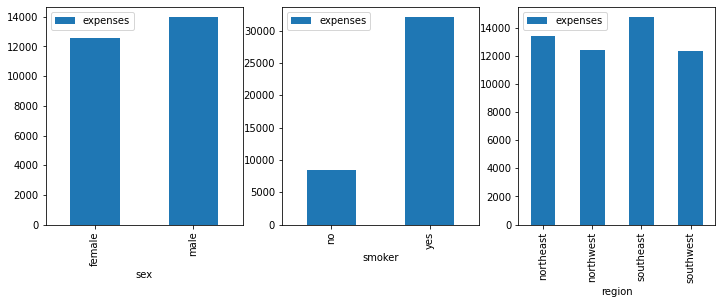

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cols = [f for f in dataset.columns if dataset[f].dtype == 'object']
for i, feature in enumerate(cols):
    dataset[[feature,'expenses']].groupby(feature).mean().plot(kind='bar',ax=axes[i])

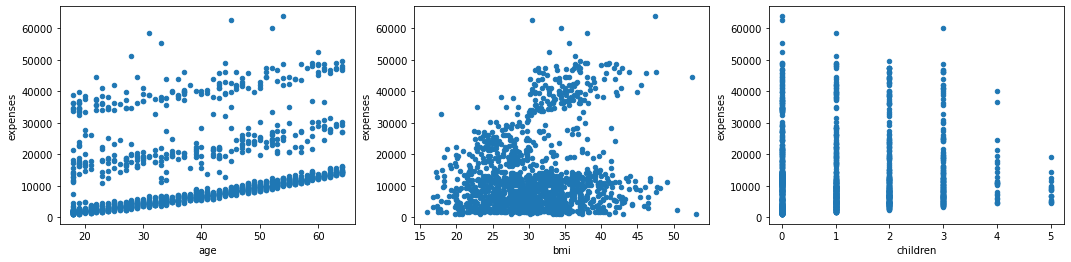

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
cols = [f for f in dataset.columns if f!= 'expenses' and dataset[f].dtype != 'object']
for i, feature in enumerate(cols):
    dataset.plot.scatter(x=feature,y='expenses',ax=axes[i])

In [6]:
df = dataset.copy()

In [7]:
# Preprocessing data
feature_columns = {}
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        c = df[col_name].astype('category')
        df[col_name] = c.cat.codes
        feature_columns[col_name] = dict(enumerate(c.cat.categories))

In [8]:
# Check the convertion of categorical data to numerical values
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [9]:
# check dictionary of encoding for categorical features
feature_columns

{'region': {0: 'northeast', 1: 'northwest', 2: 'southeast', 3: 'southwest'},
 'sex': {0: 'female', 1: 'male'},
 'smoker': {0: 'no', 1: 'yes'}}

In [10]:
# Splitting data in training and testing datasets
train_features = df.sample(frac=0.8, random_state=0)
test_features = df.drop(train_features.index)
train_dataset = train_features.copy()
test_dataset = test_features.copy()

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [11]:
# Build data normalizer
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

In [12]:
# Define model architecture
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])
  return model

In [13]:
# Build and compile model
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [18]:
# Train model
history = model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=200)

Epoch 1/200
27/27 [==============================] - 0s 7ms/step - loss: 2107.9670 - mae: 2107.9670 - mse: 24152966.0000 - val_loss: 2347.8313 - val_mae: 2347.8313 - val_mse: 25657238.0000
Epoch 2/200
27/27 [==============================] - 0s 5ms/step - loss: 2102.4653 - mae: 2102.4653 - mse: 24028460.0000 - val_loss: 2335.5342 - val_mae: 2335.5342 - val_mse: 25514132.0000
Epoch 3/200
27/27 [==============================] - 0s 5ms/step - loss: 2097.0869 - mae: 2097.0869 - mse: 23987982.0000 - val_loss: 2332.0168 - val_mae: 2332.0168 - val_mse: 25404054.0000
Epoch 4/200
27/27 [==============================] - 0s 5ms/step - loss: 2088.6743 - mae: 2088.6743 - mse: 23886906.0000 - val_loss: 2320.0476 - val_mae: 2320.0476 - val_mse: 25314850.0000
Epoch 5/200
27/27 [==============================] - 0s 5ms/step - loss: 2084.6760 - mae: 2084.6760 - mse: 23804156.0000 - val_loss: 2312.4294 - val_mae: 2312.4294 - val_mse: 25199482.0000
Epoch 6/200
27/27 [==============================] - 0s

In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

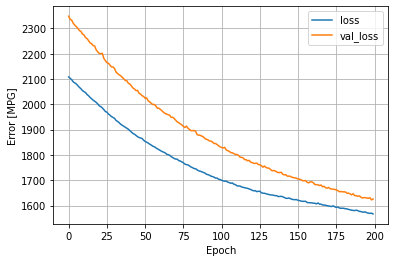

In [19]:
plot_loss(history)

9/9 - 0s - loss: 2328.1565 - mae: 2328.1565 - mse: 32900998.0000 - 42ms/epoch - 5ms/step
Testing set Mean Abs Error: 2328.16 expenses
You passed the challenge. Great job!


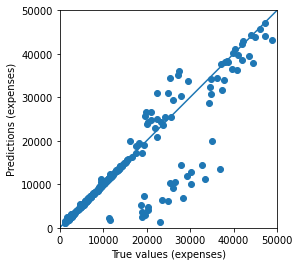

In [20]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
